# Activity of water ($a_{H_2O}$) vs. $X_{H_2SO_4}$

In this notebook we will plot activity of water vs $H_2SO_4$ concentration (\%wt) and (\mol fraction). It will create interpolation functions that can be used to convert %wt, mol fraction, moles/L and molality (moles/Kg of H2O).

The activity data is from "The Thermodynamic Properties of Aqueous Sulfuric Acid Solutions and Hydrates from 15 to 300°K." W. F. Giauque, E. W. Hornung, J. E. Kunzler, and T. R. Rubin, *J. Am. Chem. Soc.*, **1960**, *82*, 62-70. https://doi.org/10.1021/ja01486a014

Note: The water activity is for its activity as a material. In its standard state $a_{H_2O} = 1$. As impurities are added this will reduce. The value is actually the "effective mole fraction" of water. i.e. it behaves as the mole fraction $a_{H_2O}$ compared to pure water.

A discussion of values can be found at "Activity and Activity Coefficient of Water in Aqueous Solutions and Their Relationships with Solution Structure Parameters.", O. Miyawaki, A. Saito, T. Matsuo, K. Nakamura, *Bioscience, Biotechnology, and Biochemistry*, **1997**, *61*, 466-469, https://doi.org/10.1271/bbb.61.466

The activity coefficient of water can be calculated as $\gamma_{H_2O} = a_{H_2O}/X_{H_2O}$ where $X_{H_2O}$ is the actual mole fraction of water.

In [12]:
##############################################################
### Set up libraries and global variables
##############################################################

Data_File_Name = "01_Giauque_Table9_activityH2OinH2SO4.csv"

import interpolators   ### import the following functions from local library
# interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byMoleFraction()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress

from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
github_H0_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/H0_data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.08
molwtH20 = 18.0
densityH2SO4 = 1.83
densityH2O = 1.000

### interpolation = interp1d(x1, y1, kind='linear')
### interpolation = CubicSpline(x1, y1)
### interpolation = scipy.interpolate.make_smoothing_spline(x1, y1, w=None, lam=0.03)



In [13]:
##############################################################
### Import the data and perform calculations
##############################################################

Filename = github_location + Data_File_Name

df1 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 

#display(df1)

molal = df1["conc H2SO4 / m"]
mass_add_to_1_kg_water = molal * molwtH2SO4
total_mass_solution = mass_add_to_1_kg_water + 1000
percent_H2SO4 = mass_add_to_1_kg_water / total_mass_solution * 100

df1["%H2SO4"] = percent_H2SO4
df1["mole fraction"] = molal / (molal + 1000/molwtH20)

#display(df1)

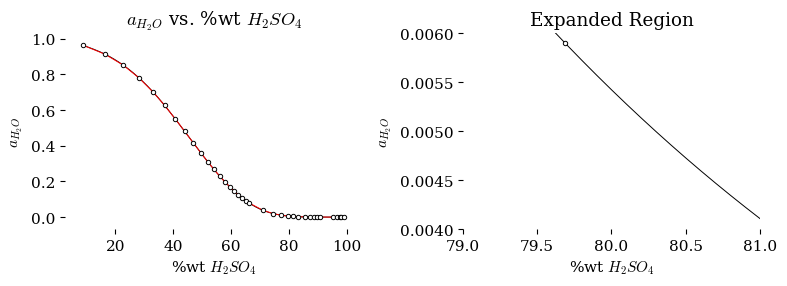

In [14]:
###################################################
### Get the data
###################################################

x = df1["%H2SO4"]
y = df1["a_H2O"]

###################################################
### Interpolate the data
###################################################

### Using a smoothing interpolation function that returns a Bspline function

interpolation = make_smoothing_spline(x, y,      ### The x and y data
                                      w=None,    ### A list of weights for each point (default = None)
                                      lam=0.03)  ### A factor for the degree of smoothing. Change this to change the smoothness.
step = 0.01
x_smooth = np.arange(np.min(x), np.max(x)+step, step)
y_smooth = interpolation(x_smooth)

interp = interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
y_int = interp(x)

###################################################
### Set zoom range for second plot
###################################################

zoom_xlim=[79,81]                  
zoom_ylim=[0.004,0.006]

###################################################
### Set up labels for plots
###################################################

x_label = "%wt ${H_2SO_4}$"
y_label = "$a_{H_2O}$"

Title0 = "$a_{H_2O}$ vs. %wt $H_2SO_4$"
Title1 = "Expanded Region"

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))  

###########################
### Set up rectangle for box patch
###########################

vertices = []
codes = []

codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
vertices = [(zoom_xlim[0], zoom_ylim[0]), 
            (zoom_xlim[0], zoom_ylim[1]), 
            (zoom_xlim[1], zoom_ylim[1]), 
            (zoom_xlim[1], zoom_ylim[0]), 
            (0, 0)]

path = Path(vertices, codes)
pathpatch0 = PathPatch(path, edgecolor='lightgray', facecolor='white', linewidth=0.5, zorder = 0)

###################################################
###################################################

###################################################
### Make the first plot (plot 0)
###################################################

ax[0].set(
          title = Title0,       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
       )
ax[0].margins(x=.07, y=.07, tight=True)

# ax[0].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)   # A vertical line highlight

ax[0].scatter(x, y, 
              marker = "o", 
              s = 10, 
              color = "white", 
              edgecolors = "black", 
              linewidths=0.7, 
              zorder = 2)

ax[0].add_patch(pathpatch0)   # add the box to highlight the zoom area

#ax[0].plot(x, y, "-", color = "black", linewidth=0.7, zorder = 1)
ax[0].plot(x_smooth, y_smooth, "-", color = "black", linewidth=0.7, zorder = 1)
ax[0].plot(x, y_int, "-", color = "red", linewidth=0.7, zorder = 1)


###################################################
### Make the second plot (plot 1)
###################################################

ax[1].set(
          title = Title1,       
          ylabel=y_label, 
          xlabel=x_label,                
          xlim=zoom_xlim,      ### Set axis limits to zoom in         
          ylim=zoom_ylim
       )
ax[1].margins(x=.07, y=.07, tight=True)

# ax[1].axvline(x=30, ymin=0.1, ymax = 0.9, linewidth = 0.5, color = "lightgray", zorder = 0)   # A vertical line highlight

ax[1].scatter(x, y, 
              marker = "o", 
              s = 10, 
              color = "white", 
              edgecolors = "black", 
              linewidths=0.7, 
              zorder = 2)


#ax[1].plot(x, y, "-", color = "black", linewidth=0.7, zorder = 1)
ax[1].plot(x_smooth, y_smooth, "-", color = "black", linewidth=0.7, zorder = 1)

plt.show()

In [15]:
###################################################
### Create Interpolation Function
###################################################

### This function below could be in an external library that you call in your own program.

def MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt():
    Data_File_Name = "01_Giauque_Table9_activityH2OinH2SO4.csv"

    import pandas as pd
    import numpy as np
    from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.
    
    #github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
    github_location = "./data/"
    
    molwtH2SO4 = 98.08; molwtH20 = 18.0; densityH2SO4 = 1.83; densityH2O = 1.000
    
    Filename = github_location + Data_File_Name
    
    df1 = pd.read_csv(Filename, 
                     delimiter = ",", 
                     skipinitialspace=True, 
                     comment = "#") 
    
    molal = df1["conc H2SO4 / m"]
    mass_add_to_1_kg_water = molal * molwtH2SO4
    total_mass_solution = mass_add_to_1_kg_water + 1000
    percent_H2SO4 = mass_add_to_1_kg_water / total_mass_solution * 100
    
    df1["%H2SO4"] = percent_H2SO4
    df1["mole fraction"] = molal / (molal + 1000/molwtH20)
    
    x = df1["%H2SO4"]
    y = df1["a_H2O"]
    
    interpolation = make_smoothing_spline(x, y,      ### The x and y data
                                          w=None,    ### A list of weights for each point (default = None)
                                          lam=0.03)  ### A factor for the degree of smoothing. Change this to change the smoothness.
    
    return(interpolation)

###################################################
### call the function to create an interpolator for activity H2O in H2SO4
###################################################

interpolator = MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()

###################################################
### An example of using the inerpolation function that you just created
###################################################

percentH2SO4 = 80

H2Oactivity = interpolator(percentH2SO4)

print(f"The activity of water in {percentH2SO4}% H2SO4 is {H2Oactivity:0.3f}")


The activity of water in 80% H2SO4 is 0.005


In [16]:
print(df1)


    conc H2SO4 / m         a_H2O  gamma_H2SO4     %H2SO4  mole fraction
0                1  9.622000e-01       0.1300   8.931954       0.017682
1                2  9.130000e-01       0.1253  16.399144       0.034749
2                3  8.514000e-01       0.1411  22.734578       0.051233
3                4  7.800000e-01       0.1683  28.177430       0.067164
4                5  7.035000e-01       0.2062  32.903918       0.082569
5                6  6.257000e-01       0.2540  37.046737       0.097473
6                7  5.503000e-01       0.3150  40.707713       0.111901
7                8  4.806000e-01       0.3850  43.966290       0.125874
8                9  4.175000e-01       0.4640  46.885357       0.139415
9               10  3.611000e-01       0.5550  49.515347       0.152542
10              11  3.113000e-01       0.6560  51.897175       0.165275
11              12  2.678000e-01       0.7660  54.064383       0.177632
12              13  2.303000e-01       0.8840  56.044729       0